In [1]:
import xarray
import numpy as np
from matplotlib import pyplot as plt

import os

In [115]:
adcp_datapath = '/home/cha674/Work/IN2024_V04/'
#adcp_filename = 'os150nb.nc'
adcp_filename = 'os75nb.nc'

adcp_dataset = xarray.open_dataset(os.path.join(adcp_datapath,adcp_filename)).load()
#adcp_dataset.close()


In [3]:
adcp_dataset.time.max()

<xarray.DataArray 'time' ()>
array('2024-06-19T07:25:12.000000000', dtype='datetime64[ns]')

In [4]:
ctd_datapath = '/run/user/336728/gvfs/smb-share:server=data.investigator.csiro.au,share=voyages/in2024_v04/ctd/processing/in2024_v04/cap/cappro/avg'
ctd_files =  []

ctd_lats   = []
ctd_lons   = []
ctd_times   = []



list_dir = os.listdir(ctd_datapath)

for i_file in list_dir:
    if os.path.isfile(os.path.join(ctd_datapath,i_file) ) and i_file.endswith('.nc'):
        ctd_files.append(i_file)
        
        current_ctd_file = xarray.open_dataset(os.path.join(ctd_datapath,i_file))
        
        ctd_lons.append(current_ctd_file['longitude'].values)
        ctd_lats.append(current_ctd_file['latitude'].values)
        ctd_times.append(current_ctd_file['time'].values)
        
ctd_times = np.asarray(ctd_times)
ctd_lons  = np.asarray(ctd_lons)
ctd_lats  = np.asarray(ctd_lats)


In [5]:
bathy_file = '/run/user/336728/gvfs/smb-share:server=data.investigator.csiro.au,share=science-team/Solitary_Island_Canyon_High_Res_Bathy.nc'
bathy_dataset = xarray.open_dataset(bathy_file)

In [6]:
bathy_dataset

<xarray.Dataset>
Dimensions:  (lat: 1417, lon: 1607)
Coordinates:
  * lat      (lat) float64 -30.41 -30.41 -30.41 -30.41 ... -29.7 -29.7 -29.7
  * lon      (lon) float64 153.3 153.3 153.3 153.3 ... 154.1 154.1 154.1 154.1
Data variables:
    crs      |S1 ...
    Band1    (lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.4.0, released 2021/11/04
    history:      Wed Jun 12 11:38:37 2024: GDAL CreateCopy( /mnt/ClipZipShip...

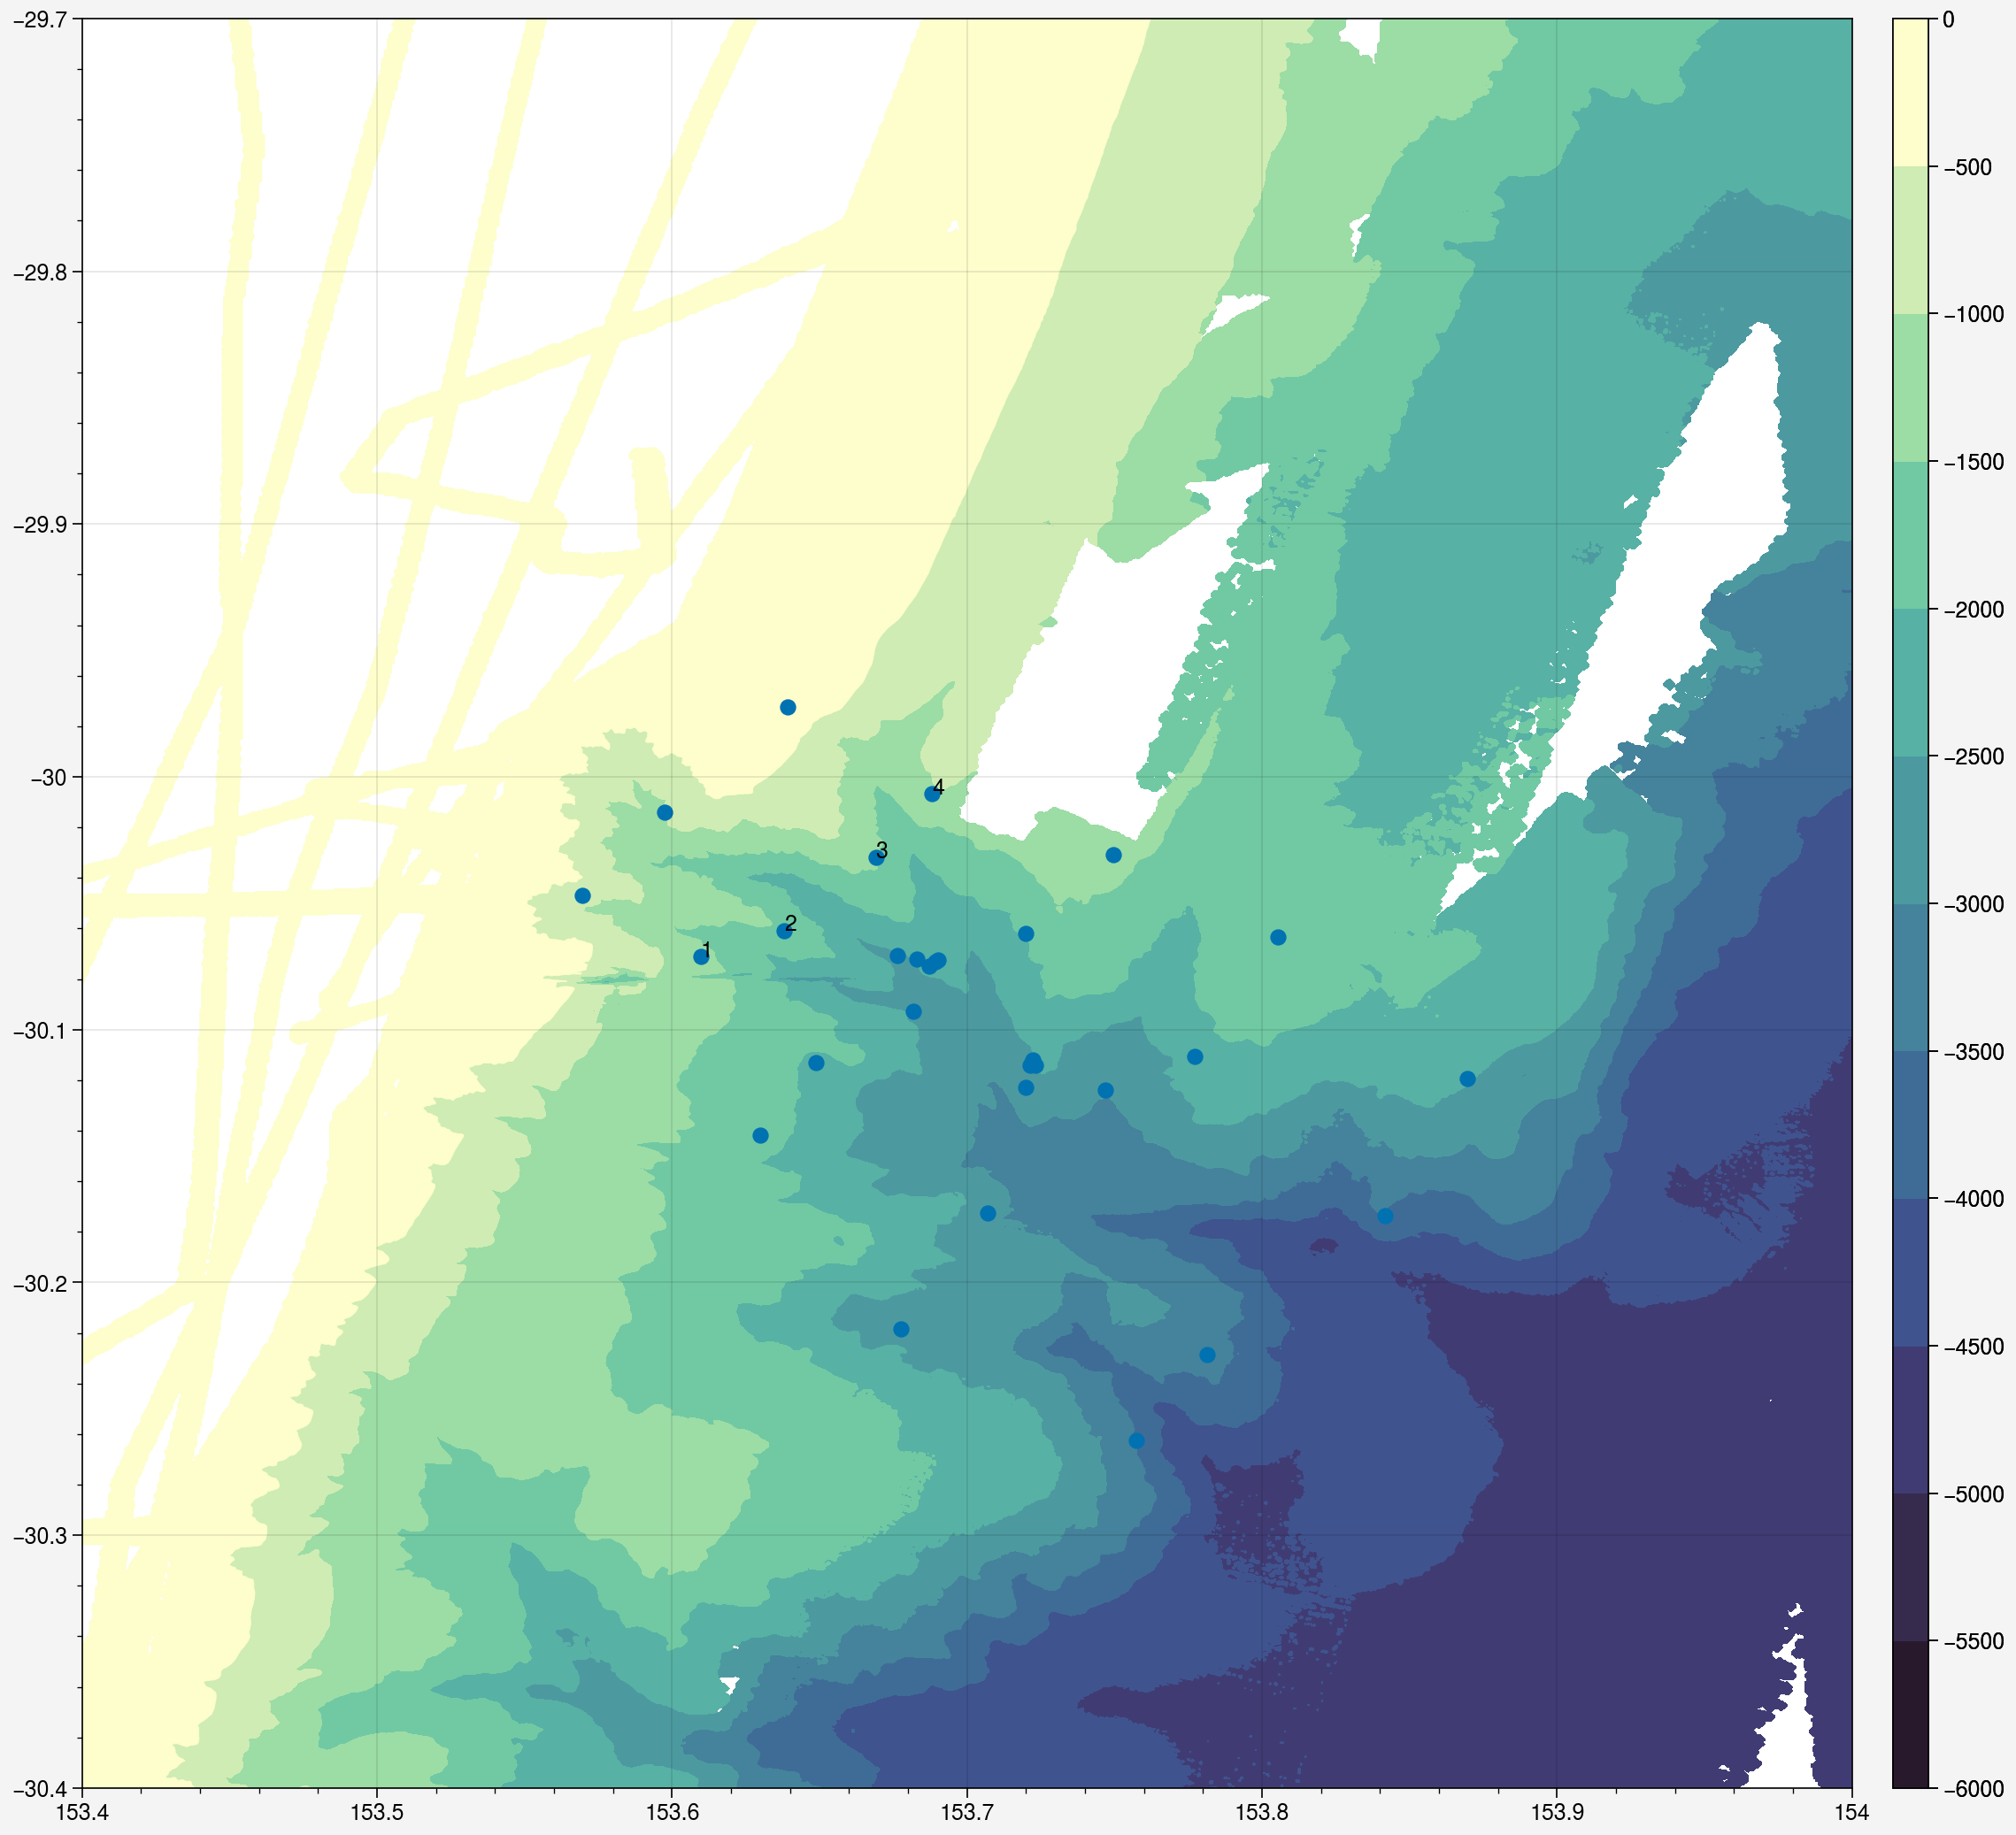

In [119]:
import proplot
#proplot.rc.reso = 'hi'


# Zooming in on continents
fig = proplot.figure(refwidth=10)
ax = fig.subplots(ncols=1,nrows=1) #, proj='cyl', proj_kw={'lon_0': 150})
cs = ax[0].contourf(bathy_dataset['lon'].values,bathy_dataset['lat'].values,bathy_dataset['Band1'].values,levels=np.arange(-6000,1,500),cmap='deep_r')
ax[0].scatter(ctd_lons,ctd_lats)
ax[0].set_ylim((-30.4, -29.7))
ax[0].set_xlim((153.4, 154))

#ax[0].format(latlim=(-30.4, -29.7), lonlim=(153.4, 154),land='True',landcolor='grey',lonlabels='left')
ctd_counter =1

#ctd_index_to_plot = [25,26,27]
ctd_index_to_plot = [29,28,30,31]
#ctd_index_to_plot = [7,6,8,9,10]
#ctd_index_to_plot = np.arange(1,len(ctd_files))
for i_ctd in ctd_index_to_plot:
    i_file_name = ctd_files[i_ctd]
    ax[0].annotate(ctd_counter, (ctd_lons[i_ctd],ctd_lats[i_ctd]), xytext=None, xycoords='data')
    ctd_counter = ctd_counter+1
    
fig.colorbar(cs)

In [15]:
def distance(s_lat, s_lng, e_lat, e_lng):

   # Approximate radius of earth in km
   R = 6373.0e3

   s_lat = s_lat*np.pi/180.0
   s_lng = np.deg2rad(s_lng)
   e_lat = np.deg2rad(e_lat)
   e_lng = np.deg2rad(e_lng)

   d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

   return 2 * R * np.arcsin(np.sqrt(d))

In [127]:
from scipy import stats as scipy_stats

#ctd_index_to_plot = [25,26,27]
ctd_index_to_plot = [29,28,30,31]

ctd_transect_lats = ctd_lats[ctd_index_to_plot]
ctd_transect_lons = ctd_lons[ctd_index_to_plot]
ctd_transect_times = ctd_times[ctd_index_to_plot]


max_time = np.max(ctd_transect_times)
min_time = np.min(ctd_transect_times)



adcp_dataset_for_transect = adcp_dataset.sel(time=slice(min_time,max_time))

max_lat = adcp_dataset_for_transect['lat'].max()
max_lon = adcp_dataset_for_transect['lon'].max()

min_lat = adcp_dataset_for_transect['lat'].min()
min_lon = adcp_dataset_for_transect['lon'].min()


lon_grid = np.linspace(min_lon,max_lon,20)
lat_grid = np.linspace(min_lat,max_lat,20)



adcp_depth = adcp_dataset_for_transect['depth'][0,:]

u_binned = np.zeros([lon_grid.size,adcp_depth.size],dtype='float32')
v_binned = np.zeros([lon_grid.size,adcp_depth.size],dtype='float32')

distance_threshold = 1000.0

for i_point in range(0,lon_grid.size):
    distance_to_adcp = distance(adcp_dataset_for_transect['lat'].values, adcp_dataset_for_transect['lon'].values, lat_grid[i_point], lon_grid[i_point])
    idx_to_get = np.nonzero(distance_to_adcp<distance_threshold)[0]

    u_mean = np.nanmean(adcp_dataset_for_transect['u'][idx_to_get,:],axis=0)
    v_mean = np.nanmean(adcp_dataset_for_transect['v'][idx_to_get,:],axis=0)

    u_binned[i_point,:] = u_mean
    v_binned[i_point,:] = v_mean


/tmp/ipykernel_30919/3867021821.py:41: RuntimeWarning: Mean of empty slice
  u_mean = np.nanmean(adcp_dataset_for_transect['u'][idx_to_get,:],axis=0)
/tmp/ipykernel_30919/3867021821.py:42: RuntimeWarning: Mean of empty slice
  v_mean = np.nanmean(adcp_dataset_for_transect['v'][idx_to_get,:],axis=0)


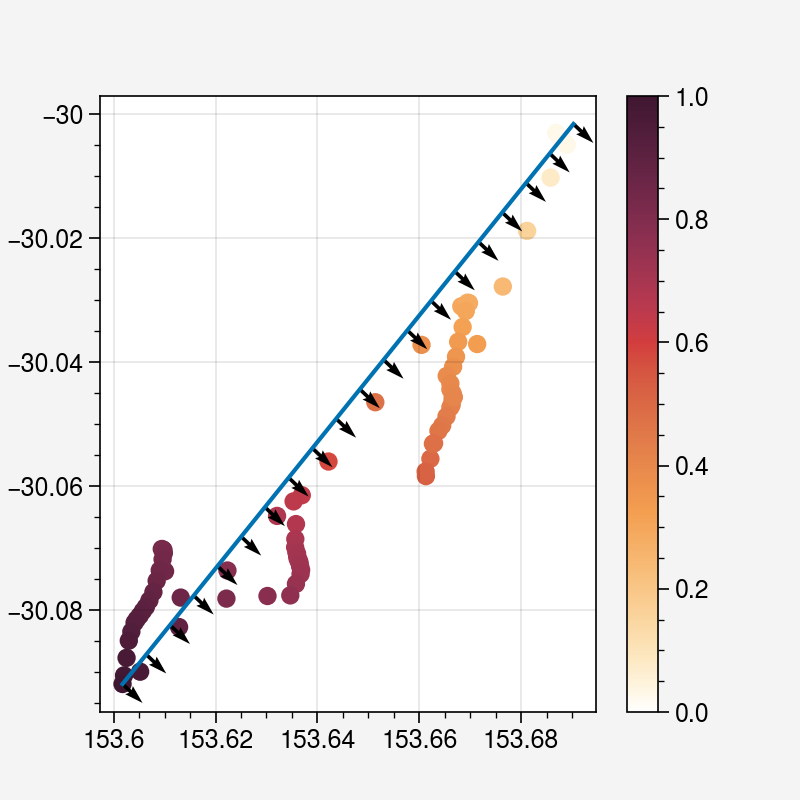

In [128]:
cs = plt.scatter(adcp_dataset_for_transect['lon'],adcp_dataset_for_transect['lat'],c=distance_to_adcp)
plt.plot(lon_grid,lat_grid)
plt.quiver(lon_grid,lat_grid,normal_x,normal_y)
plt.colorbar()

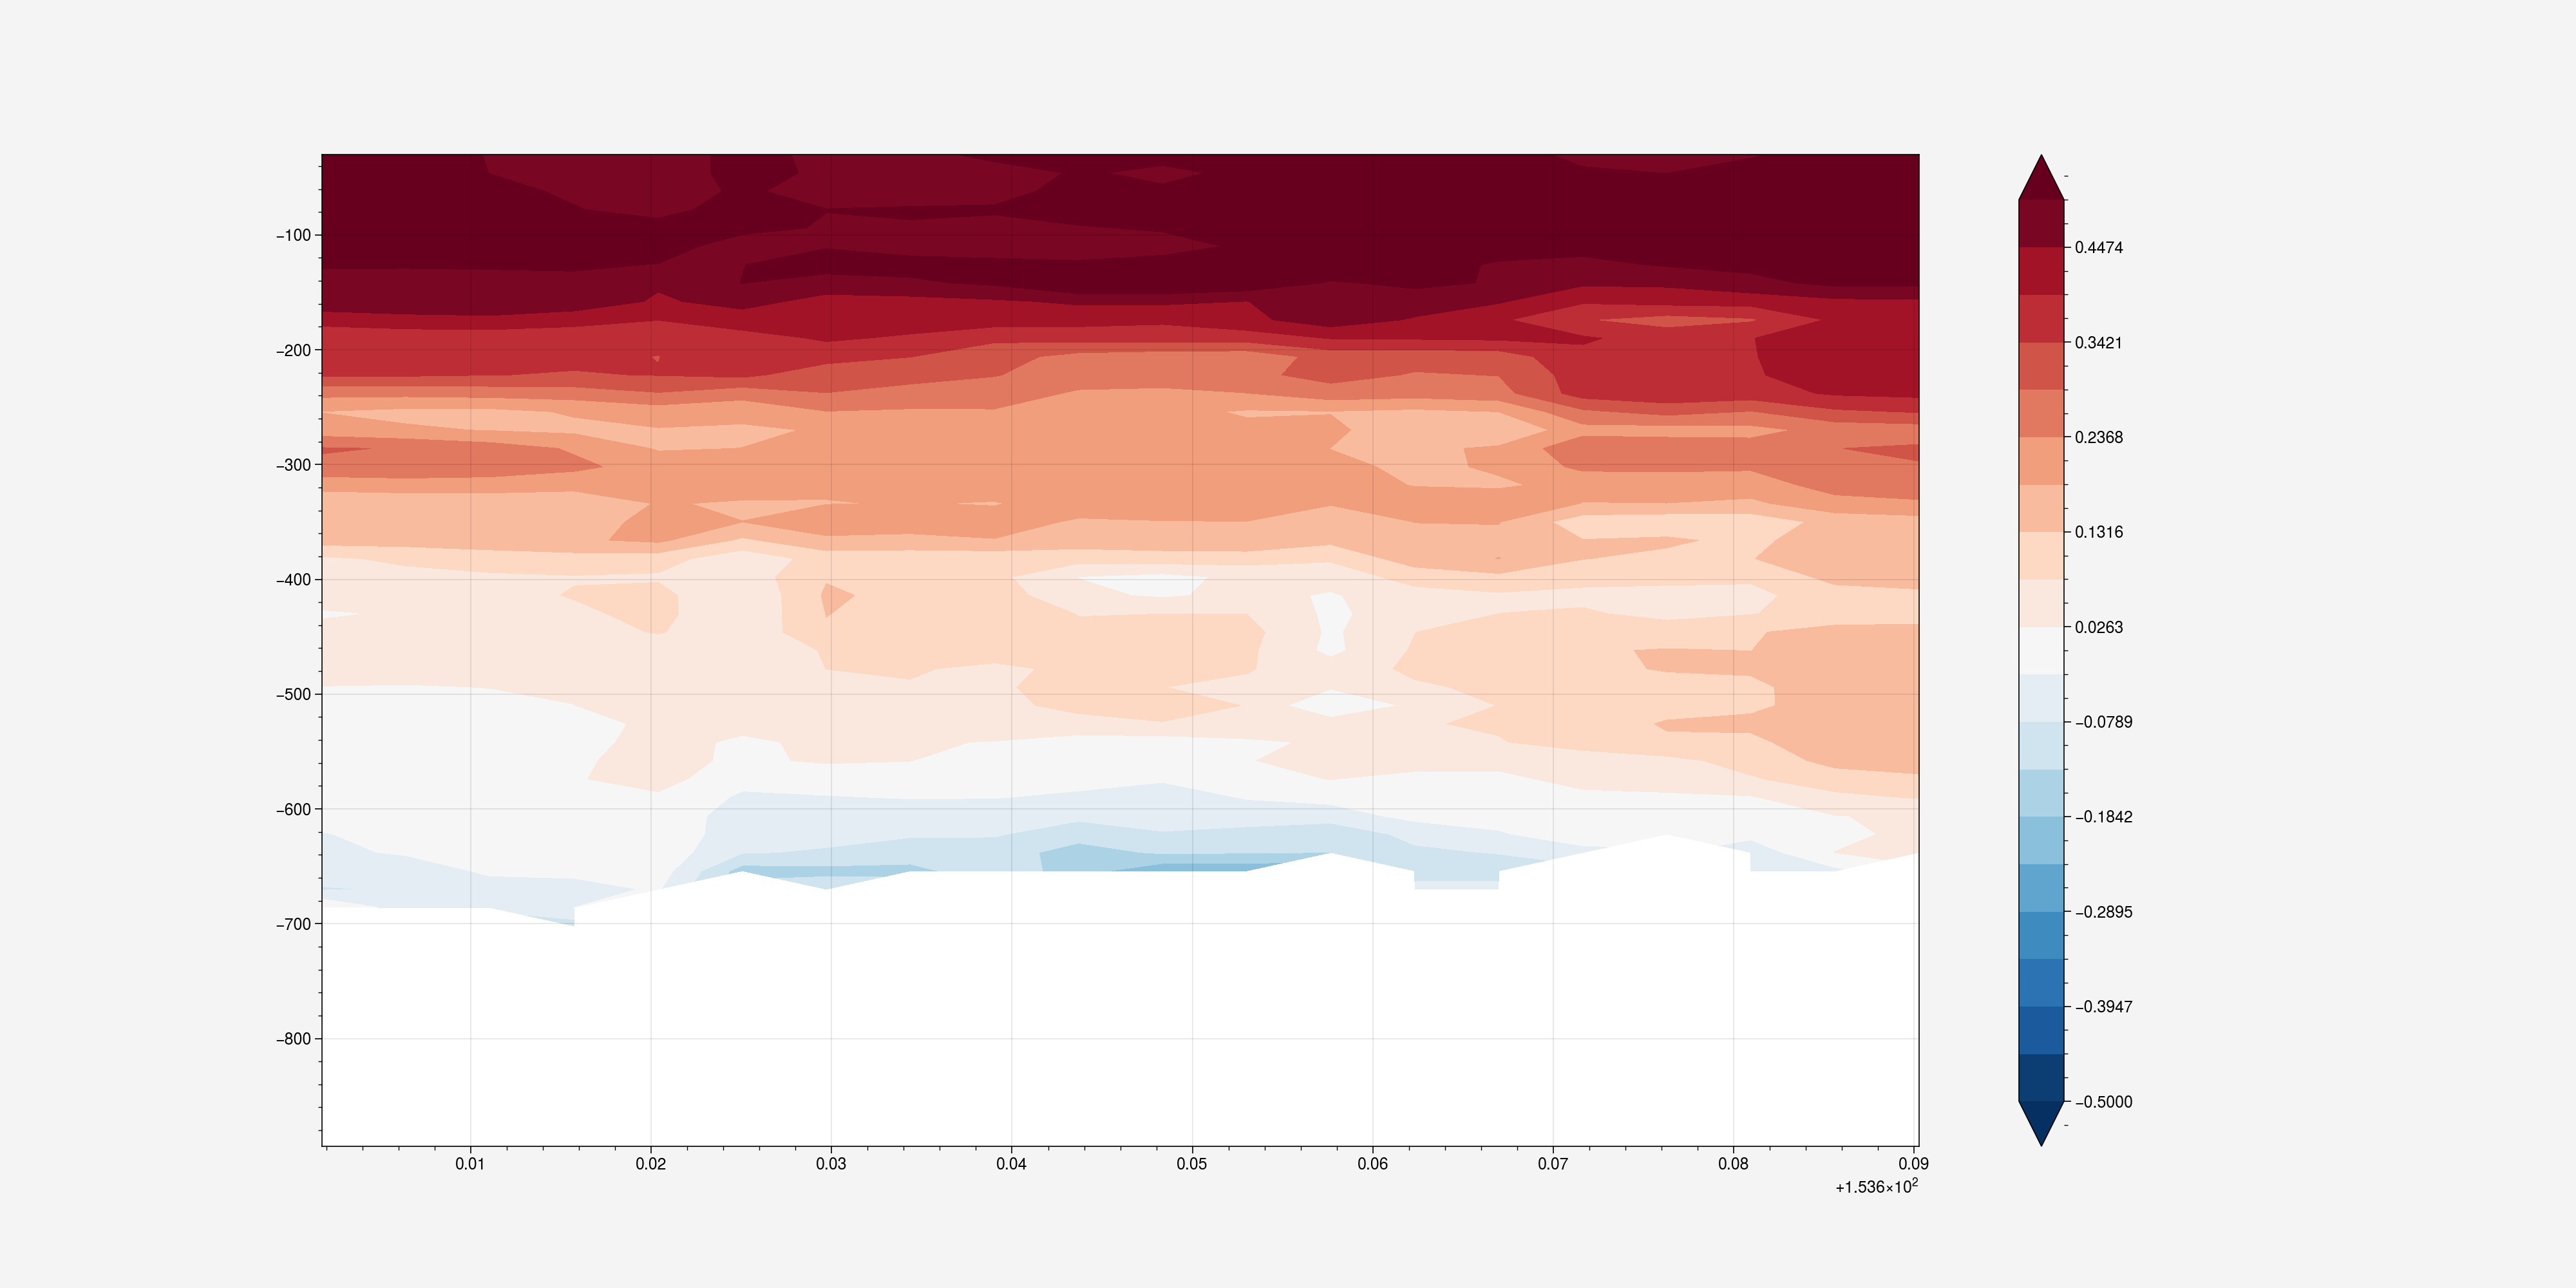

In [129]:
tangent_vector = np.asarray([np.diff(lon_grid),np.diff(lat_grid)]) 
tangent_vector = tangent_vector / np.sqrt(tangent_vector[0,:]*tangent_vector[0,:] + tangent_vector[1,:]*tangent_vector[1,:])

tangent_vector = np.hstack([tangent_vector[:,0][:,np.newaxis],tangent_vector ]) #,axis=0)

normal_x =  tangent_vector[1,:]
normal_y = -tangent_vector[0,:]



normal_velocity  = normal_x[:,np.newaxis]*u_binned + normal_y[:,np.newaxis]*v_binned

plt.figure(1,figsize=(20,10))
plt.contourf(lon_grid,-adcp_depth,normal_velocity.T,np.linspace(-0.50,0.50,20),cmap='RdBu_r',extend='both')
plt.colorbar()


In [79]:
tangent_vector

array([[0.00466126, 0.00466126, 0.00466126, 0.00466126, 0.00466126,
        0.00466126, 0.00466126, 0.00466126, 0.00466126, 0.00466126,
        0.00466126, 0.00466126, 0.00466126, 0.00466126, 0.00466126,
        0.00466126, 0.00466126, 0.00466126, 0.00466126],
       [0.00475102, 0.00475102, 0.00475102, 0.00475102, 0.00475102,
        0.00475102, 0.00475102, 0.00475102, 0.00475102, 0.00475102,
        0.00475102, 0.00475102, 0.00475102, 0.00475102, 0.00475102,
        0.00475102, 0.00475102, 0.00475102, 0.00475102]])

In [77]:
adcp_dataset_for_transect.time

<xarray.DataArray 'time' (time: 42)>
array(['2024-06-15T23:46:33.000000000', '2024-06-15T23:51:33.000000000',
       '2024-06-15T23:56:33.000000000', '2024-06-16T00:01:32.000000000',
       '2024-06-16T00:06:32.000000000', '2024-06-16T00:11:33.000000002',
       '2024-06-16T00:16:33.000000000', '2024-06-16T00:21:33.000000000',
       '2024-06-16T00:26:33.000000000', '2024-06-16T00:31:32.000000000',
       '2024-06-16T00:36:33.000000000', '2024-06-16T00:41:33.000000000',
       '2024-06-16T00:46:33.000000000', '2024-06-16T00:51:33.000000000',
       '2024-06-16T00:56:33.000000002', '2024-06-16T01:01:33.000000000',
       '2024-06-16T01:06:33.000000000', '2024-06-16T01:11:33.000000000',
       '2024-06-16T01:16:33.000000000', '2024-06-16T01:21:33.000000000',
       '2024-06-16T01:26:33.000000000', '2024-06-16T01:31:32.000000000',
       '2024-06-16T01:36:33.000000000', '2024-06-16T01:41:33.000000002',
       '2024-06-16T01:46:31.999999998', '2024-06-16T01:51:32.000000000',
       '2024-06-16T01:56:33.000000000', '2024-06-16T02:01:33.000000000',
       '2024-06-16T02:06:33.000000000', '2024-06-16T02:11:32.000000000',
       '2024-06-16T02:16:33.000000000', '2024-06-16T02:21:33.000000000',
       '2024-06-16T02:26:33.000000002', '2024-06-16T02:31:33.000000000',
       '2024-06-16T02:36:33.000000000', '2024-06-16T02:41:33.000000000',
       '2024-06-16T02:46:33.000000000', '2024-06-16T02:51:33.000000000',
       '2024-06-16T02:56:33.000000000', '2024-06-16T03:01:32.000000000',
       '2024-06-16T03:06:33.000000000', '2024-06-16T03:11:32.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2024-06-15T23:46:33 ... 2024-06-16T03:11:32
Attributes:
    long_name:      Decimal day
    C_format:       %12.5f
    standard_name:  time
    axis:           T
    data_min:       164.8251273148148
    data_max:       170.30916666666667

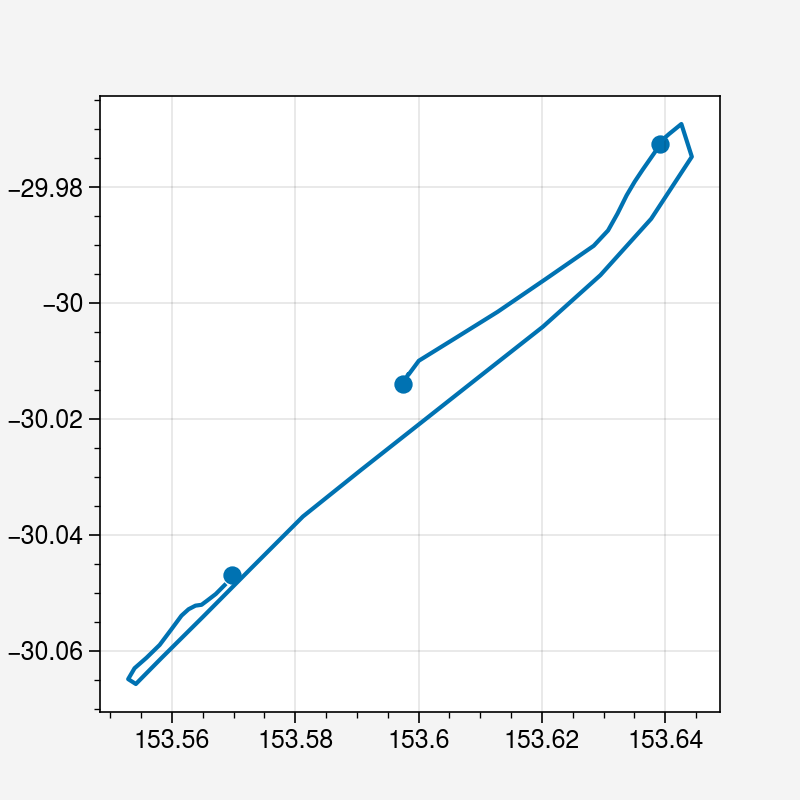

In [39]:
plt.plot(adcp_dataset_for_transect['lon'],adcp_dataset_for_transect['lat'])
plt.scatter(ctd_transect_lons,ctd_transect_lats)

In [41]:
min_time

numpy.datetime64('2024-06-15T23:43:07.421002240')

In [42]:
max_time

numpy.datetime64('2024-06-16T03:13:05.255004672')